# (Bonus notebook) Training with a minimal version of the dataset

This is a demo on how to run the training script with downloaded data inside Colab. Note that this is just a fast demo (the "mini" dataset here doesn't represent the full data) and that some small alterations in code were made to allow running in Colab - for full runs, please install the code on your own machine.

## 1 Prepare code, data and libraries

In [1]:
!pip install --quiet rasterio
!pip install --quiet --upgrade gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 82.6 MB/s eta 0:00:00


In [ ]:
# Clone the repository:
!git clone https://github.com/spaceml-org/STARCOP.git

In [3]:
# Data:
# STARCOP_mini.zip with 261 MB
!gdown https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl -O STARCOP_mini.zip
!unzip -q STARCOP_mini.zip
# clean-up
!rm *.zip

# The train script will expect the test dataset in the "test.csv" - so here in this small demo we just place the small subset there instead:
!cp STARCOP_mini/test_mini10.csv STARCOP_mini/test.csv

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl
From (redirected): https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl&confirm=t&uuid=2d42d9ce-5de6-480b-a00f-b7544324584b
To: /content/STARCOP_mini.zip
100% 274M/274M [00:01<00:00, 214MB/s]


In [6]:
%cd /content/STARCOP

/content/STARCOP


In [ ]:
!pip install -r requirements.txt

In [ ]:
# additional libraries and exact versions:
!pip install git+https://github.com/spaceml-org/georeader.git
!pip install torchtext==0.14.1

In [ ]:
assert False
# please restart the runtime with the button above ^

## 2 Run the train script

In [1]:
%cd /content/STARCOP

/content/STARCOP


Here we show a sample run of the scripts.train code - with some example settings.

In [ ]:
# We will use some of the example commands also shown in this script:
#!cat bash/bash_train_example.sh

# You can also check the output of the help:
#!python -m scripts.train --help

### 2.1 Adjust the code for Colab

**When using Colab** we change few details in the code to run with the newest version of the libraries, we turn off logging with Wandb and copying data into a gs bucket.

In [2]:
%%writefile scripts/train_colab.py
import matplotlib
matplotlib.use('agg')

import os
import hydra
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from starcop.dataset_setup import get_dataset
from starcop.model_setup import get_model
from starcop.data.data_logger import ImageLogger
from hydra.utils import get_original_cwd
import logging
import fsspec
from starcop.validation import  run_validation
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt

@hydra.main(version_base=None, config_path="configs", config_name="config")
def train(settings : DictConfig) -> None:
    experiment_path = os.getcwd()
    folder_relative_name = experiment_path.replace(get_original_cwd(), "") #remove beginning of path

    log = logging.getLogger(__name__)

    checkpoint_path = os.path.join(experiment_path, "checkpoint").replace("\\", "/")
    if not experiment_path.startswith("gs://"):
        os.makedirs(experiment_path, exist_ok=True)

    if not checkpoint_path.startswith("gs://"):
        os.makedirs(checkpoint_path, exist_ok=True)

    # Set up remote path
    if folder_relative_name.startswith("/"):
        folder_relative_name = folder_relative_name[1:]
    if not folder_relative_name.endswith("/"):
        folder_relative_name += "/"
    remote_path = os.path.join("gs://starcop/", folder_relative_name)

    OmegaConf.set_struct(settings, False)
    settings["experiment_path"] = experiment_path
    settings["experiment_path"] = remote_path

    log.info(f"trained models will be save at {experiment_path}")
    log.info(f"At the end of training, models will be copied to {remote_path}")

    plt.ioff()

    # LOGGING SETUP
    log.info("SETTING UP LOGGERS")
    # Change vs the main code - commented the Wandb logging:
    # wandb_logger = WandbLogger(
    #     name=settings.experiment_name,
    #     project=settings.wandb.wandb_project,
    #     entity=settings.wandb.wandb_entity,
    # )
    # # wandb.config.update(settings)
    # wandb_logger.experiment.config.update(settings)

    # settings["wandb_logger_version"] = wandb_logger.version
    OmegaConf.set_struct(settings, True)

    log.info(f"Settings dump:{OmegaConf.to_yaml(settings)}")
    log.info(f"Using matplotlib backend: {matplotlib.get_backend()}")

    # ======================================================
    # EXPERIMENT SETUP
    # ======================================================
    # Seed
    seed_everything((None if settings.seed == "None" else settings.seed))

    # DATASET SETUP
    log.info("SETTING UP DATASET")
    data_module = get_dataset(settings)
    data_module.prepare_data()

    # MODEL SETUP
    log.info("SETTING UP MODEL")
    settings.model.test = False
    settings.model.train = True
    model = get_model(settings, settings.experiment_name)

    # CHECKPOINTING SETUP
    log.info("SETTING UP CHECKPOINTING")

    metric_monitor ="val_loss"
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_path,
        save_top_k=True,
        verbose=True,
        monitor=metric_monitor,
        mode="min"
    )

    early_stop_callback = EarlyStopping(
        monitor=metric_monitor,
        patience=settings.model.early_stopping_patience,
        strict=False,
        verbose=False,
        mode="min"
    )

    # Images for logs from the first batch
    batch_train = next(iter(data_module.train_plot_dataloader(batch_size=settings.plot_samples)))
    batch_test = next(iter(data_module.test_plot_dataloader(batch_size=settings.plot_samples)))

    # il = ImageLogger(batch_train=batch_train,
    #                  batch_test=batch_test, products_plot=settings.products_plot,
    #                  input_products=settings.dataset.input_products)
    #callbacks = [checkpoint_callback, il]
    callbacks = [checkpoint_callback]

    # TRAINING SETUP
    log.info("START TRAINING")

    # See: https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html
    trainer = Trainer(
        fast_dev_run=False,
        logger=None, ### < change
        callbacks=callbacks,
        default_root_dir=experiment_path,
        accumulate_grad_batches=1,
        gradient_clip_val=0.0,
        benchmark=False,
        accelerator=settings.training.accelerator,
        devices=settings.training.devices,
        max_epochs=settings.training.max_epochs,
        # check_val_every_n_epoch=settings.training.val_every,
        val_check_interval=settings.training.val_check_interval,
        # Pass a float in the range [0.0, 1.0] to check after a fraction of the training epoch. Pass an int to check after a fixed number of training batches. An int value can only be higher than the number of training batches when
        log_every_n_steps=settings.training.train_log_every_n_steps,

        #no longer used in newer versions of the library:
        #auto_select_gpus=True,
        #auto_lr_find=False,
        #resume_from_checkpoint=checkpoint_path if settings.resume_from_checkpoint else None,
    )

    trainer.fit(model, data_module)

    # Save model
    trainer.save_checkpoint(os.path.join(experiment_path, "final_checkpoint_model.ckpt"))

    print("Training finished!")

if __name__ == "__main__":
    train()


Writing scripts/train_colab.py


### 2.2 Run the training script

We will be using this training script:


```
python -m scripts.train \
  dataset.input_products=["mag1c","TOA_AVIRIS_640nm","TOA_AVIRIS_550nm","TOA_AVIRIS_460nm"] \
  # ^ selects the input products, in this case it's 4 products, the mag1c + RGB
  model.model_type='unet_semseg' model.pos_weight=1 \
  experiment_name="HyperSTARCOP_magic_rgb_DEMO" \
  dataloader.num_workers=4 dataset.use_weight_loss=True \
  training.val_check_interval=0.5 \
  training.max_epochs=5 \
  # ^ how many epochs?
  products_plot=["rgb_aviris","mag1c","label","pred","differences"] \
  # ^ which visualisation scripts should be called - matters mostly when logging to wandb, which is turned off here
  dataset.weight_sampling=True \
  dataset.train_csv="train_mini10.csv" dataset.root_folder=$root_folder
  # ^ important, selects which csv files will be used to load data and the root folder
  
```






In [3]:
import omegaconf
import pylab as plt
import torch
import omegaconf
import fsspec
import os
import json
import pandas as pd
import numpy as np
from starcop.torch_utils import to_device
import starcop.plot as starcoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

from starcop.data.datamodule import Permian2019DataModule
from starcop.models.model_module import ModelModule
from starcop.validation import run_validation

device = torch.device("cuda:0")
fs = fsspec.filesystem("gs")
config_general = omegaconf.OmegaConf.load("scripts/configs/config.yaml")
root_folder = "/content/STARCOP_mini"

In [4]:
!python -m scripts.train_colab dataset.input_products=["mag1c","TOA_AVIRIS_640nm","TOA_AVIRIS_550nm","TOA_AVIRIS_460nm"] model.model_type='unet_semseg' model.pos_weight=1 experiment_name="HyperSTARCOP_magic_rgb_DEMO" dataloader.num_workers=4 dataset.use_weight_loss=True training.val_check_interval=0.5 training.max_epochs=5 products_plot=["rgb_aviris","mag1c","label","pred","differences"] dataset.weight_sampling=True dataset.train_csv="train_mini10.csv" dataset.root_folder=$root_folder

[2023-11-16 18:41:05,639][__main__][INFO] - trained models will be save at /content/STARCOP/experiments/HyperSTARCOP_magic_rgb_DEMO/2023-11-16_18-41
[2023-11-16 18:41:05,639][__main__][INFO] - At the end of training, models will be copied to gs://starcop/experiments/HyperSTARCOP_magic_rgb_DEMO/2023-11-16_18-41/
[2023-11-16 18:41:05,639][__main__][INFO] - SETTING UP LOGGERS
[2023-11-16 18:41:05,642][__main__][INFO] - Settings dump:experiment_name: HyperSTARCOP_magic_rgb_DEMO
seed: None
resume_from_checkpoint: false
wandb:
  wandb_project: your_wandb_project
  wandb_entity: your_wandb_entity
  images_logging: wandb
dataloader:
  batch_size: 32
  num_workers: 4
products_plot:
- rgb_aviris
- mag1c
- label
- pred
- differences
plot_samples: 8
dataset:
  input_products:
  - mag1c
  - TOA_AVIRIS_640nm
  - TOA_AVIRIS_550nm
  - TOA_AVIRIS_460nm
  output_products:
  - labelbinary
  use_weight_loss: true
  weight_loss: weight_mag1c
  training_size:
  - 128
  - 128
  training_size_overlap:
  - 64


In [5]:
# Our training gets saved into:
!ls /content/STARCOP/experiments/HyperSTARCOP_magic_rgb_DEMO/
# (note the last folder name comes from the data - change it to your own)
saved_model_path = "/content/STARCOP/experiments/HyperSTARCOP_magic_rgb_DEMO/2023-11-16_18-41"

!ls $saved_model_path -lauh

2023-11-16_18-41
total 77M
drwxr-xr-x 4 root root 4.0K Nov 16 18:44 .
drwxr-xr-x 3 root root 4.0K Nov 16 18:43 ..
drwxr-xr-x 2 root root 4.0K Nov 16 18:42 checkpoint
-rw-r--r-- 1 root root  77M Nov 16 18:44 final_checkpoint_model.ckpt
drwxr-xr-x 2 root root 4.0K Nov 16 18:41 .hydra
-rw-r--r-- 1 root root 3.5K Nov 16 18:41 train_colab.log


## 3 Check the trained model

Note: this snippet is from model inference notebook, here we just aim it at the locally trained model...

In [6]:
import omegaconf
import pylab as plt
import torch
import omegaconf
import fsspec
import os
import json
import pandas as pd
import numpy as np
from starcop.torch_utils import to_device
import starcop.plot as starcoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

from starcop.data.datamodule import Permian2019DataModule
from starcop.models.model_module import ModelModule
from starcop.validation import run_validation

device = torch.device("cuda:0")
fs = fsspec.filesystem("gs")
config_general = omegaconf.OmegaConf.load("scripts/configs/config.yaml")
root_folder = "/content/STARCOP_mini"

In [7]:
hsi_model_path = os.path.join(saved_model_path,"final_checkpoint_model.ckpt")
hsi_config_path = os.path.join(saved_model_path,".hydra/config.yaml")

In [8]:
def load_model_with_datamodule(model_path, config_path):
    config_model = omegaconf.OmegaConf.load(config_path)
    config = omegaconf.OmegaConf.merge(config_general, config_model)

    import ast
    #dataset_dict = ast.literal_eval(config_model['_content']['value']['dataset'])
    dataset_dict = config_model['dataset']
    dataset_dict['root_folder'] = root_folder
    dataset_dict['train_csv'] = '/content/STARCOP_mini/train_mini10.csv'
    config.dataset = dataset_dict
    #config.products_plot = config_model['_content']['value']['products_plot']
    config.products_plot = config_model['products_plot']

    data_module = Permian2019DataModule(config)
    data_module.test_csv = '/content/STARCOP_mini/test_mini10.csv'
    data_module.settings['dataset'] = dataset_dict
    data_module.prepare_data()

    model = ModelModule.load_from_checkpoint(model_path, settings=config)
    model.to(device)
    model.eval() # !

    print("Loaded model with",model.num_channels,"input channels, data module with", len(data_module.input_products), "inputs:", data_module.input_products, ", for plotting we use these products:", config.products_plot)

    return model, data_module, config

hsi_model, hsi_dm, hsi_config = load_model_with_datamodule(hsi_model_path, hsi_config_path)
print("successfully loaded HyperSTARCOP model!")

Loaded model with 4 input channels, data module with 4 inputs: ['mag1c', 'TOA_AVIRIS_640nm', 'TOA_AVIRIS_550nm', 'TOA_AVIRIS_460nm'] , for plotting we use these products: ['rgb_aviris', 'mag1c', 'label', 'pred', 'differences']
successfully loaded HyperSTARCOP model!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


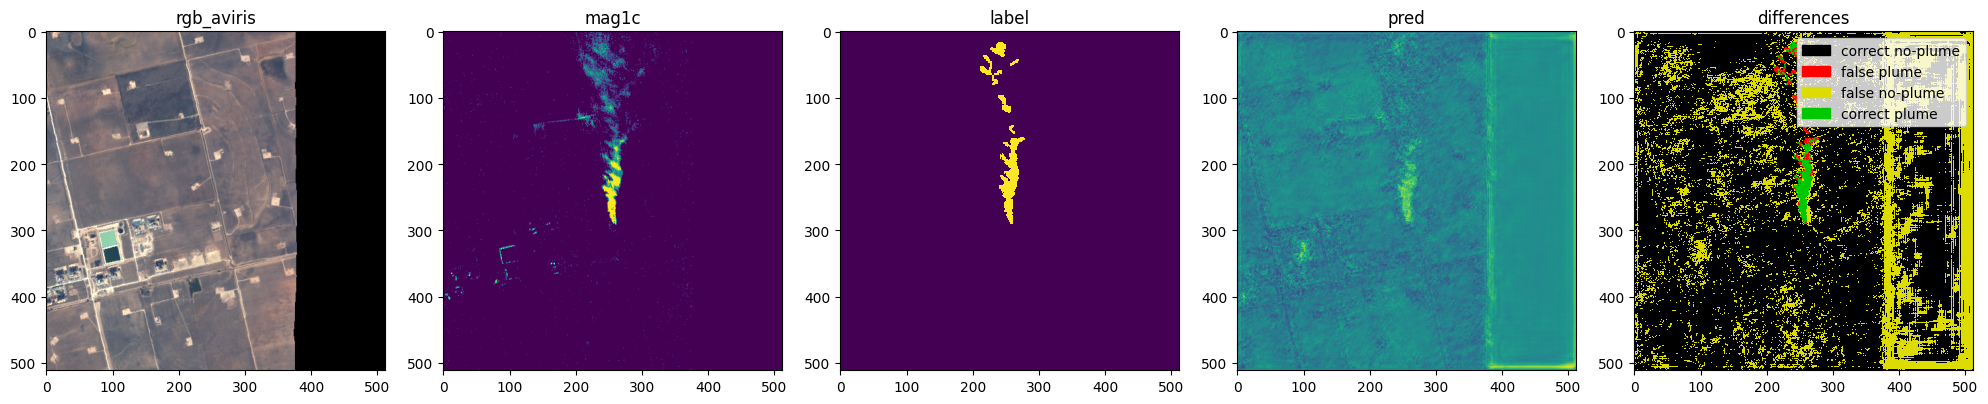

In [9]:
dataloader = hsi_dm.test_dataloader(batch_size=1)
how_many = 1
for i, plume_data in enumerate(dataloader):
    plume_data = hsi_model.batch_with_preds(to_device(plume_data, hsi_model.device))
    fig = starcoplot.plot_batch(to_device(plume_data,"cpu"), input_products=hsi_config.dataset.input_products,
                                products_plot=hsi_config.products_plot, figsize_ax=(4, 4))

    plt.show(fig)
    plt.close()

    how_many -=1
    if how_many <= 0: break

In [ ]:
# ^ The results of the model we just trained, note that with the "mini" dataset, these results aren't really all that good!